# Project in Mahine Learning

Loading packages

In [1]:
from utility import *
from scipy.signal import savgol_filter

In [3]:
try :
    X1, X2, Y1 = open_data("C:\\Users\\Louis Lovat\\Desktop\\UNIF\\MachineLearning\\Project\\data")
except :
    X1, X2, Y1 = open_data("C:\\Users\\hchri\\Jupyter\\Machine learning\\project_data")
    
X2.drop(["title", "is_adult", "img_url", "description", "Unnamed: 0"], axis=1, inplace=True)
X1_p = X1.drop(["title", "is_adult", "img_url", "description", "Unnamed: 0"], axis=1)
colmns = ['ratings','n_votes','production_year','runtime','release_year']

# General preprocessing

X1_p = Binarize(X1_p, 'studio', 10)
X1_p = Binarize(X1_p, 'genres', 5)

X1_p = strToFloatArray(X1_p, "text_embeddings")
X1_p = strToFloatArray(X1_p, "img_embeddings")


In [4]:
mean_cst = 0
mean_line = 0
Linear = Process(X1_p, Y1)

for i in range(20):
    Linear.setTrainTest()
    Linear.X_train.fillna(Linear.X_train["runtime"].mean(), inplace=True)
    Linear.X_test.fillna(Linear.X_test["runtime"].mean(), inplace=True)
    
    ## Feature selection
    Linear.removeDuplicate()
    
    Linear.PCA_embeddings("text_embeddings", 100)
    Linear.PCA_embeddings("img_embeddings", 100)

    #Linear.emb_most_corr("text_embeddings")
    #Linear.emb_most_corr("img_embeddings")

    Linear.removeDuplicate()
    Linear.corrThreshold()
    
    # outliers ?
    
    ## regression
    
    Linear.addModel("linear")
    pred = Linear.useModel("linear")
    
    mean_cst += compute_rmse(float(Linear.Y_train.mean())*1e-6*np.ones(len(Linear.Y_test)), Linear.Y_test*1e-6)
    mean_line += compute_rmse(pred, Linear.Y_test*1e-6)
    print(str(i) + " lin_reg :", compute_rmse(pred, Linear.Y_test*1e-6))

print("\n avg cst :", mean_cst / 20)
print('avg lin_reg :', mean_line/20)

TypeError: unhashable type: 'numpy.ndarray'

In [15]:
mean_cst = 0
mean_knn = 0
KNN = Process(X1_p, Y1)

for i in range(20):
    KNN.setTrainTest()
    KNN.X_train.fillna(KNN.X_train["runtime"].mean(), inplace=True)
    KNN.X_test.fillna(KNN.X_test["runtime"].mean(), inplace=True)

    ## Feature selection
    
    KNN.PCA_embeddings("text_embeddings", 70)
    KNN.PCA_embeddings("img_embeddings", 70)
    KNN.removeDuplicate()
    KNN.removeRedundantFeatures(threshold = 0.8)

    #Linear.emb_most_corr("text_embeddings")
    #Linear.emb_most_corr("img_embeddings")
    
    KNN.minmaxize(withOutliers = False) # outliers ?
    KNN.corrThreshold()
    
    ## regression
    
    KNN.addModel("knn", n_neighbors = 11, p=1, weights = "uniform")
    pred = KNN.useModel("knn")
    
    mean_cst += compute_rmse(float(KNN.Y_train.mean())*1e-6*np.ones(len(KNN.Y_test)), KNN.Y_test*1e-6)
    mean_knn += compute_rmse(pred, KNN.Y_test*1e-6)
    print(str(i) + " knn_reg :", compute_rmse(pred, KNN.Y_test*1e-6))

print("\n avg cst :", mean_cst / 20)
print('avg knn_reg :', mean_knn/20)

0 knn_reg : 58.58953064431304
1 knn_reg : 58.3466474177711
2 knn_reg : 59.09405877099426
3 knn_reg : 58.37004364897851
4 knn_reg : 54.23607241738273
5 knn_reg : 55.61892046467266
6 knn_reg : 64.02198080934009
7 knn_reg : 62.364997177266346
8 knn_reg : 62.80996565690795
9 knn_reg : 49.998766518504084
10 knn_reg : 55.547926859446704
11 knn_reg : 46.12341124523366
12 knn_reg : 57.54283596638388
13 knn_reg : 54.82654540069773
14 knn_reg : 57.729283137988624
15 knn_reg : 56.66210593740994
16 knn_reg : 53.95346750389304
17 knn_reg : 59.417856195986545
18 knn_reg : 59.73866129830315
19 knn_reg : 58.22261840165342

 avg cst : 72.73433073090544
avg knn_reg : 57.16078477365638


In [5]:
process = Process(X1_p, Y1)

In [6]:
#We determine here wich number of neighbors is optimal

first = 1
last = 30
N_neighbors = [i for i in range(first, last+1)]
N_iterations = 30
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
    process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
    ## Feature selection
    process.PCA_embeddings("text_embeddings", 100)
    process.PCA_embeddings("img_embeddings", 100)
    process.removeDuplicate()
    process.removeRedundantFeatures(threshold = 0.8)
    process.corrThreshold()
    ## Feature processing
    process.minmaxize(withOutliers = False) # outliers ?

    for n_neighbors in N_neighbors:
        process.addModel("knn", n_neighbors = n_neighbors, p=2, weights = "uniform")
        pred = process.useModel("knn")
        
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[n_neighbors - first] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

11


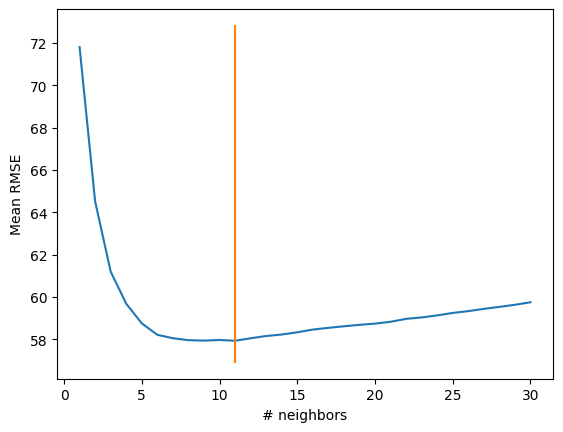

In [7]:
plt.plot(N_neighbors, results)
plt.plot([N_neighbors[np.argmin(results)], N_neighbors[np.argmin(results)]], [np.min(results)-1, np.max(results)+1])
print(N_neighbors[np.argmin(results)])
plt.ylabel("Mean RMSE")
plt.xlabel("# neighbors")
plt.show()

In [8]:
#We determine here wich minkowski metric is optimal

first = 1
last = 10
p_metrics = [i for i in range(first, last+1)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
    process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
    ## Feature selection
    process.PCA_embeddings("text_embeddings", 100)
    process.PCA_embeddings("img_embeddings", 100)
    process.removeDuplicate()
    process.removeRedundantFeatures(threshold = 0.8)
    process.corrThreshold()
    ## Feature processing
    process.minmaxize(withOutliers = False) # outliers ?

    for p in p_metrics:
        process.addModel("knn", n_neighbors = 9, p=p, weights = "uniform")
        pred = process.useModel("knn")
        
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[p - first] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

1


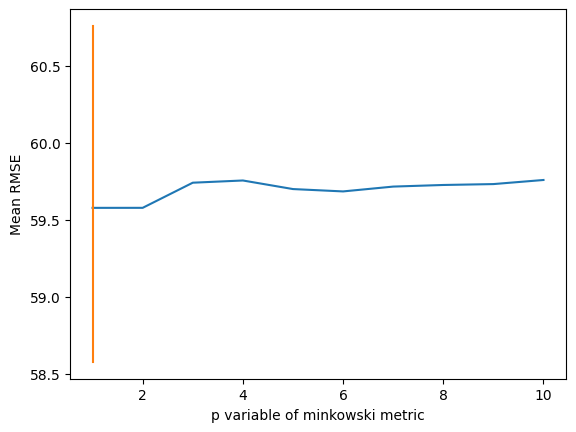

In [9]:
plt.plot(p_metrics, results)
plt.plot([p_metrics[np.argmin(results)], p_metrics[np.argmin(results)]], [np.min(results)-1, np.max(results)+1])
print(p_metrics[np.argmin(results)])
plt.ylabel("Mean RMSE")
plt.xlabel("p variable of minkowski metric")
plt.show()

In [10]:
#We determine here if we should keep the ouliers while scaling

first = 1
last = 2
outliers = [i for i in range(first, last+1)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    for outlier in outliers:
        process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
        process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
        ## Feature selection
        process.PCA_embeddings("text_embeddings", 100)
        process.PCA_embeddings("img_embeddings", 100)
        process.removeDuplicate()
        process.removeRedundantFeatures(threshold = 0.8)
        process.corrThreshold()
        ## Feature processing
        arg = False
        if outlier == 1:
            arg = True
        process.minmaxize(withOutliers = arg) # outliers ?
        process.addModel("knn", n_neighbors = 9, p=1, weights = "uniform")
        pred = process.useModel("knn")
        process.resetProcessing()
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[outlier - first] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

2


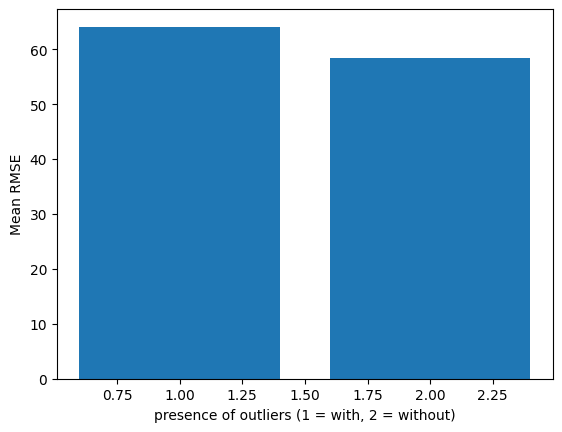

In [11]:
plt.bar(outliers, results)
print(outliers[np.argmin(results)])
plt.ylabel("Mean RMSE")
plt.xlabel("presence of outliers (1 = with, 2 = without)")
plt.show()

In [12]:
#We determine here if we should keep the ouliers 

first = 1
last = 2
outliers = [i for i in range(first, last+1)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    for outlier in outliers:
        process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
        process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
        ## Feature selection
        process.PCA_embeddings("text_embeddings", 100)
        process.PCA_embeddings("img_embeddings", 100)
        process.removeDuplicate()
        if outlier == 1:
            process.removeOutliers(colmns)
        process.removeRedundantFeatures(threshold = 0.8)
        process.corrThreshold()
        ## Feature processing
        process.minmaxize(withOutliers = False) # outliers ?
        process.addModel("knn", n_neighbors = 9, p=1, weights = "uniform")
        pred = process.useModel("knn")
        process.resetProcessing()
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[outlier - first] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

2


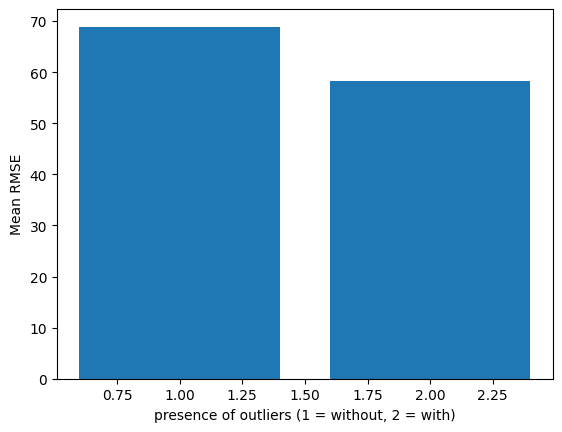

In [13]:
plt.bar(outliers, results)
print(outliers[np.argmin(results)])
plt.ylabel("Mean RMSE")
plt.xlabel("presence of outliers (1 = without, 2 = with)")
plt.show()

In [16]:
mean_cst = 0
mean_rf = 0
RF = Process(X1_p, Y1)

for i in range(20):
    RF.setTrainTest()
    RF.X_train.fillna(RF.X_train["runtime"].mean(), inplace=True)
    RF.X_test.fillna(RF.X_test["runtime"].mean(), inplace=True)

    ## Feature selection
    
    RF.PCA_embeddings("text_embeddings", 100)
    RF.PCA_embeddings("img_embeddings", 100)
    RF.removeDuplicate()
    RF.removeRedundantFeatures(threshold = 0.8)

    #Linear.emb_most_corr("text_embeddings")
    #Linear.emb_most_corr("img_embeddings")
    
    RF.minmaxize(withOutliers = False) # outliers ?
    RF.corrThreshold()
    
    
    ## regression
    RF.addModel("randomForest", n_estimators = 90)
    pred = RF.useModel("randomForest")
    
    mean_cst += compute_rmse(float(RF.Y_train.mean())*1e-6*np.ones(len(RF.Y_test)), RF.Y_test*1e-6)
    mean_rf += compute_rmse(pred, RF.Y_test*1e-6)
    print(str(i) + " rf_reg :", compute_rmse(pred, RF.Y_test*1e-6))

print("\n avg cst :", mean_cst / 20)
print('avg rf_reg :', mean_rf/20)

0 rf_reg : 59.01043170889238
1 rf_reg : 58.6625305509744
2 rf_reg : 50.716646039049984
3 rf_reg : 53.49058791664133
4 rf_reg : 62.07409245360889
5 rf_reg : 58.13979463300693
6 rf_reg : 55.82782813381308
7 rf_reg : 51.11335392809191
8 rf_reg : 62.763401685446766
9 rf_reg : 52.265499480663415
10 rf_reg : 63.21045731829528
11 rf_reg : 50.02576813046249
12 rf_reg : 57.05455767517856
13 rf_reg : 56.67518882828097
14 rf_reg : 53.57793600167145
15 rf_reg : 57.0836754912137
16 rf_reg : 56.84448239963935
17 rf_reg : 57.696904186113784
18 rf_reg : 56.95746793849946
19 rf_reg : 52.98242966883022

 avg cst : 72.47813190437842
avg rf_reg : 56.30865170841871


In [6]:
#We determine here an optimal number of trees

first = 50
last = 150
step = 10
N_estimators = [i for i in range(first, last + step, step)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    for n_estimators in N_estimators:
        process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
        process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
        ## Feature selection
        process.PCA_embeddings("text_embeddings", 100)
        process.PCA_embeddings("img_embeddings", 100)
        process.removeDuplicate()
        process.removeRedundantFeatures(threshold = 0.8)
        process.corrThreshold()
        ## Feature processing
        process.minmaxize(withOutliers = False) # outliers ?
        process.addModel("randomForest", n_estimators = n_estimators)
        pred = process.useModel("randomForest")
        process.resetProcessing()
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[(n_estimators - first) // step] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

90


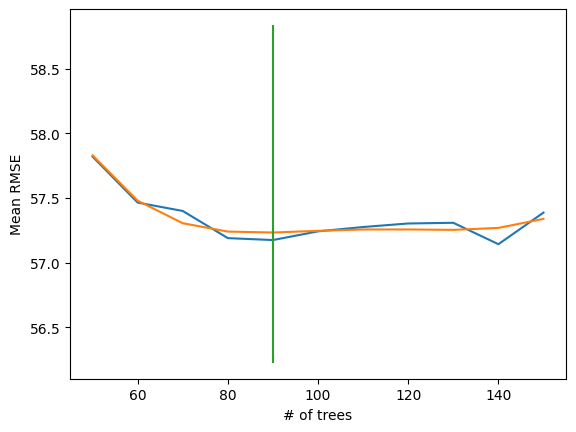

In [15]:
plt.plot(N_estimators, results)
filtered = savgol_filter(results, window_length=len(results), polyorder=4)
plt.plot(N_estimators, filtered)
plt.plot([N_estimators[np.argmin(filtered)], N_estimators[np.argmin(filtered)]], [np.min(filtered)-1, np.max(filtered)+1])
print(N_estimators[np.argmin(filtered)])
plt.ylabel("Mean RMSE")
plt.xlabel("# of trees")
plt.show()

In [21]:
#We determine here an optimal number of trees

first = 70
last = 150
step = 5
N_pca = [i for i in range(first, last + step, step)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    for n_pca in N_pca:
        process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
        process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
        ## Feature selection
        process.PCA_embeddings("text_embeddings", n_pca)
        process.PCA_embeddings("img_embeddings", n_pca)
        process.removeDuplicate()
        process.removeRedundantFeatures(threshold = 0.8)
        process.corrThreshold()
        ## Feature processing
        process.minmaxize(withOutliers = False) # outliers ?
        process.addModel("knn", n_neighbors = 11, p=1, weights = "uniform")
        pred = process.useModel("knn")
        process.resetProcessing()
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[(n_pca - first) // step] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

130


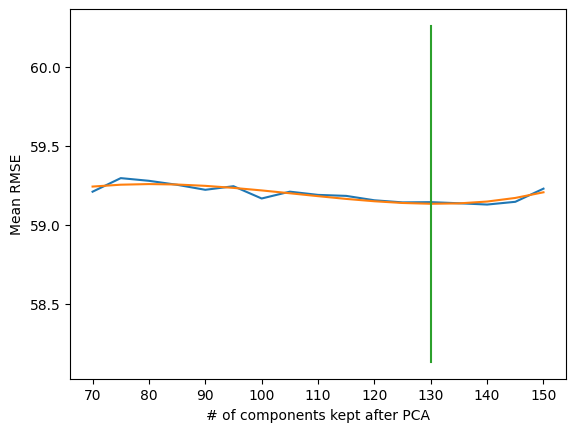

In [22]:
plt.plot(N_pca, results)
filtered = savgol_filter(results, window_length=len(results), polyorder=4)
plt.plot(N_pca, filtered)
plt.plot([N_pca[np.argmin(filtered)], N_pca[np.argmin(filtered)]], [np.min(filtered)-1, np.max(filtered)+1])
print(N_pca[np.argmin(filtered)])
plt.ylabel("Mean RMSE")
plt.xlabel("# of components kept after PCA")
plt.show()

In [16]:
#We determine here an optimal number of trees

first = 1
last = 80
step = 5
N_pca = [i for i in range(first, last + step, step)]
N_iterations = 20
results = []
for iteration in range(N_iterations):
    process.setTrainTest()
    for n_pca in N_pca:
        process.X_train.fillna(process.X_train["runtime"].mean(), inplace=True)
        process.X_test.fillna(process.X_test["runtime"].mean(), inplace=True)
        ## Feature selection
        process.PCA_embeddings("text_embeddings", n_pca)
        process.PCA_embeddings("img_embeddings", n_pca)
        process.removeDuplicate()
        process.removeRedundantFeatures(threshold = 0.8)
        process.corrThreshold()
        ## Feature processing
        process.minmaxize(withOutliers = False) # outliers ?
        process.addModel("knn", n_neighbors = 11, p=1, weights = "uniform")
        pred = process.useModel("knn")
        process.resetProcessing()
        if iteration == 0:
            results.append(compute_rmse(pred, process.Y_test*1e-6) / N_iterations)
        else :
            results[(n_pca - first) // step] += compute_rmse(pred, process.Y_test*1e-6) / N_iterations
    print("iteration %d DONE" % iteration, end="\r")

1


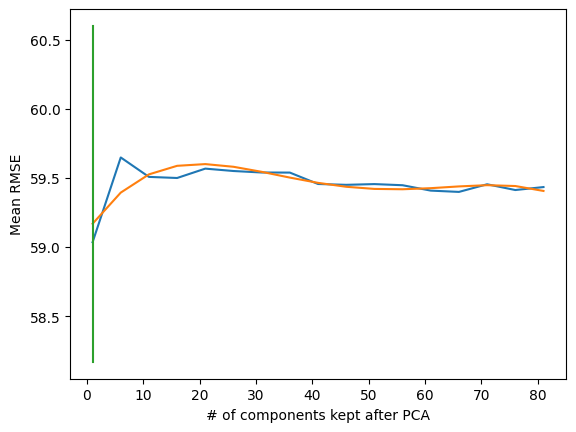

In [20]:
plt.plot(N_pca, results)
filtered = savgol_filter(results, window_length=len(results), polyorder=4)
plt.plot(N_pca, filtered)
plt.plot([N_pca[np.argmin(filtered)], N_pca[np.argmin(filtered)]], [np.min(filtered)-1, np.max(filtered)+1])
print(N_pca[np.argmin(filtered)])
plt.ylabel("Mean RMSE")
plt.xlabel("# of components kept after PCA")
plt.show()

In [ ]:
mean_cst = 0
mean_mlp = 0
MLP = Process(X1_p, Y1)

for i in range(20):
    MLP.setTrainTest()
    MLP.X_train.fillna(MLP.X_train["runtime"].mean(), inplace=True)
    MLP.X_test.fillna(MLP.X_test["runtime"].mean(), inplace=True)

    ## Feature selection
    
    MLP.PCA_embeddings("text_embeddings", 100)
    MLP.PCA_embeddings("img_embeddings", 100)
    MLP.removeDuplicate()
    MLP.removeRedundantFeatures(threshold = 0.8)

    #Linear.emb_most_corr("text_embeddings")
    #Linear.emb_most_corr("img_embeddings")
    
    MLP.minmaxize(withOutliers = False) # outliers ?
    MLP.corrThreshold()
    
    hidden_layer_sizes=np.array([100,100,100])
    activation='relu'
    max_iter=200
    ## regression
    MLP.addModel("mlp", hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=max_iter)
    pred = MLP.useModel("mlp")
    
    mean_cst += compute_rmse(float(MLP.Y_train.mean())*1e-6*np.ones(len(MLP.Y_test)), MLP.Y_test*1e-6)
    mean_mlp += compute_rmse(pred, MLP.Y_test*1e-6)
    print(str(i) + " mlp_reg :", compute_rmse(pred, MLP.Y_test*1e-6))

print("\n avg cst :", mean_cst / 20)
print('avg mlp_reg :', mean_mlp/20)